# CHAPTER 11 - The Best of Both Worlds: Hybrid Architectures - PennyLane Code

## Overview

This chapter demonstrates **hybrid quantum-classical neural networks** that combine:
- **Classical neural network layers** (Dense layers with activation functions)
- **Quantum layers** (parameterized quantum circuits)
- **Hyperparameter optimization** using Optuna

The notebook covers:
1. **Binary classification** with a hybrid model (20 → 4 classical → 1 quantum output)
2. **Hyperparameter tuning** to find optimal learning rates
3. **Multi-class classification** (3 classes) with softmax output

**Key adaptations for compatibility:**
- Custom `QuantumLayer` class with manual gradient computation (parameter-shift rule)
- Custom training loops instead of `model.fit()`
- Uses `autograd` interface for quantum circuits (not TensorFlow interface)
- Compatible with your existing library versions


*Note*: You may skip the following installation cells if you have already installed the right versions of all the libraries mentioned in *Appendix D*. This will likely NOT be the case if you are running this notebook on a cloud service such as Google Colab.

**Important - Version Compatibility**: 
PennyLane 0.26 requires specific versions for compatibility:
- **TensorFlow 2.9-2.11** (not 2.12+)
- **Keras 2.x (legacy)** via tf-keras package
- Using custom quantum layers with manual gradient computation (parameter-shift rule)
- **After installing, restart the kernel and run cells in order**


In [1]:
%pip install scikit-learn>=1.2.1


Note: you may need to restart the kernel to use updated packages.


In [2]:
# PennyLane 0.26 works best with TensorFlow 2.10 (most stable version)
%pip install "tensorflow==2.10.1"


  Using cached tensorflow-2.10.1-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl.metadata (806 bytes)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.10.1-cp310-cp310-win_amd64.whl (455.9 MB)
Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)

  Attempting uninstall: keras

    Found existing installation: keras 3.12.0

   ---------------------------------------- 0/5 [keras]
   ---------------------------------------- 0/5 [keras]
    Uninstalling keras-3.12.0:
   ---------------------------------------- 0/5 [keras]
   ---------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.20.1 requires tensorflow<2.21,>=2.20, but you have tensorflow 2.10.1 which is incompatible.


In [3]:
%pip install pennylane==0.26


In [4]:
%pip install matplotlib>=3.5.0


Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install optuna>=3.0.0


Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install tf-keras for legacy Keras 2.x support (required for PennyLane 0.26)
%pip install tf-keras


  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl.metadata (4.6 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl (331.7 MB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached keras-3.12.0-py3-none-any.whl (1.5 MB)
Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl (436 kB)

  Attempting uninstall: tensorboard-data-server

    Found existing installation: tensorboard-data-server 0.6.1

    Uninstalling tensorboard-data-server-0.6.1:

      Successfully uninstalled tensorboard-data-server-0.6.1

  Attempting uninstall: protobuf

    Found existing installation: protobuf 3.19.6

    Uninstallin

In [1]:
# Fix for Keras 3.x compatibility with PennyLane 0.26
# This must be set BEFORE importing tensorflow
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"


In [2]:
import numpy as np
import tensorflow as tf

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.datasets import make_classification

In [5]:
tf.keras.backend.set_floatx('float64')

In [6]:
import pennylane as qml

state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

c:\Users\jebar\miniconda3\envs\myenv1\lib\site-packages\pennylane\__init__.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [7]:
import matplotlib.pyplot as plt

def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [8]:
x, y = make_classification(n_samples = 1000, n_features = 20)

In [9]:
x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)


In [10]:
def TwoLocal(nqubits, theta, reps = 1):
    
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires = i)
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires = i)

In [11]:
nqubits = 4
dev = qml.device("default.qubit", wires = nqubits)

def qnn_circuit(inputs, theta):
    qml.AngleEmbedding(inputs, range(nqubits))
    TwoLocal(nqubits, theta, reps = 2)
    return qml.expval(qml.Hermitian(M, wires = [0]))

# Use autograd interface instead of TensorFlow for compatibility
qnn = qml.QNode(qnn_circuit, dev, interface="autograd")

n_params = 12  # For TwoLocal with reps=2 and 4 qubits


In [12]:
# Create a custom Keras layer with manual gradient computation
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, qnode, n_params, output_dim=1):
        super().__init__()
        self.qnode = qnode
        self.n_params = n_params
        self.output_dim = output_dim
        # Initialize trainable weights
        self.theta = self.add_weight(
            name='theta',
            shape=(n_params,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float64
        )
    
    def call(self, inputs):
        # Get current theta values
        theta_np = self.theta.numpy()
        
        # Convert inputs to numpy if needed
        if isinstance(inputs, tf.Tensor):
            inputs_np = inputs.numpy()
        else:
            inputs_np = inputs
        
        # Forward pass - compute outputs for all samples
        outputs = []
        for sample in inputs_np:
            result = self.qnode(sample, theta_np)
            outputs.append(result)
        
        outputs = np.array(outputs, dtype=np.float64).reshape(-1, self.output_dim)
        
        # Convert to TensorFlow tensor
        return tf.constant(outputs, dtype=tf.float64)
    
    def compute_gradients(self, inputs, upstream_grad):
        """Manually compute gradients using parameter-shift rule."""
        theta_np = self.theta.numpy()
        
        # Convert inputs to numpy if needed
        if isinstance(inputs, tf.Tensor):
            inputs_np = inputs.numpy()
        else:
            inputs_np = inputs
        
        # Convert upstream_grad to numpy if needed
        if isinstance(upstream_grad, tf.Tensor):
            upstream_grad_np = upstream_grad.numpy()
        else:
            upstream_grad_np = upstream_grad
        
        batch_size = len(inputs_np)
        
        # Initialize gradient accumulator
        total_grad = np.zeros_like(theta_np)
        
        # Parameter-shift rule: shift = pi/2
        shift = np.pi / 2
        
        # For each sample in the batch
        for i, sample in enumerate(inputs_np):
            # For each parameter
            for j in range(len(theta_np)):
                theta_plus = theta_np.copy()
                theta_minus = theta_np.copy()
                theta_plus[j] += shift
                theta_minus[j] -= shift
                
                # Compute gradient using parameter-shift
                grad_j = (self.qnode(sample, theta_plus) - self.qnode(sample, theta_minus)) / 2.0
                
                # Accumulate gradient weighted by upstream gradient for this sample
                if self.output_dim == 1:
                    total_grad[j] += upstream_grad_np[i, 0] * grad_j
                else:
                    # For multi-output, grad_j is an array
                    total_grad[j] += np.sum(upstream_grad_np[i] * grad_j)
        
        return tf.constant(total_grad, dtype=tf.float64)

# Create the quantum layer
qlayer = QuantumLayer(qnn, n_params=n_params, output_dim=1)


In [13]:
# Build the hybrid model with classical and quantum layers
# Note: We don't use Sequential.build() to avoid graph mode execution
classical_layer = tf.keras.layers.Dense(4, activation="sigmoid")

# Store references for training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

print("Hybrid model layers created. Ready for training!")


Hybrid model layers created. Ready for training!


In [14]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=1,
    restore_best_weights=True)

In [17]:
# Custom training functions for hybrid model
def train_step_hybrid(x_batch, y_batch):
    """Perform one training step with manual gradient computation for quantum layer."""
    # Forward pass through classical layer
    classical_output = classical_layer(x_batch)
    
    # Forward pass through quantum layer
    predictions = qlayer(classical_output)
    
    # Compute loss (binary crossentropy)
    epsilon = 1e-7
    predictions_clipped = tf.clip_by_value(predictions, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(
        y_batch * tf.math.log(predictions_clipped) + 
        (1 - y_batch) * tf.math.log(1 - predictions_clipped)
    )
    
    # Compute gradients manually
    # Gradient of loss w.r.t. predictions
    d_loss_d_pred = (predictions_clipped - y_batch.reshape(-1, 1)) / len(y_batch)
    
    # Get quantum parameter gradients using parameter-shift rule
    quantum_grads = qlayer.compute_gradients(classical_output, d_loss_d_pred.numpy())
    
    # Backpropagate through classical layer using a fresh tape
    with tf.GradientTape(persistent=False) as tape:
        classical_output_new = classical_layer(x_batch)
        # Create a differentiable proxy loss for classical layers
        # We approximate by running forward pass again
        predictions_new = qlayer(classical_output_new)
        predictions_new_clipped = tf.clip_by_value(predictions_new, epsilon, 1 - epsilon)
        loss_classical = -tf.reduce_mean(
            y_batch * tf.math.log(predictions_new_clipped) + 
            (1 - y_batch) * tf.math.log(1 - predictions_new_clipped)
        )
    
    # Get gradients for classical layer variables
    classical_grads = tape.gradient(loss_classical, classical_layer.trainable_variables)
    
    # Apply gradients
    optimizer.apply_gradients([(quantum_grads, qlayer.theta)])
    if classical_grads[0] is not None:
        optimizer.apply_gradients(zip(classical_grads, classical_layer.trainable_variables))
    
    return loss

def evaluate_hybrid(x, y):
    """Evaluate the hybrid model."""
    classical_output = classical_layer(x)
    predictions = qlayer(classical_output)
    epsilon = 1e-7
    predictions_clipped = tf.clip_by_value(predictions, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(
        y * tf.math.log(predictions_clipped) + 
        (1 - y) * tf.math.log(1 - predictions_clipped)
    )
    return loss.numpy()

def predict_hybrid(x):
    """Make predictions with the hybrid model."""
    classical_output = classical_layer(x)
    return qlayer(classical_output).numpy()

print("Custom training functions for hybrid model defined. Ready to train!")


Custom training functions for hybrid model defined. Ready to train!


In [18]:
# Custom training loop with early stopping
import time

batch_size = 10
epochs = 50
patience = 2

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_classical_weights = None
best_quantum_weights = None

print("Starting training...")
for epoch in range(epochs):
    epoch_start = time.time()
    
    # Shuffle training data
    indices = np.random.permutation(len(x_tr))
    x_tr_shuffled = x_tr[indices]
    y_tr_shuffled = y_tr[indices]
    
    # Training
    epoch_losses = []
    num_batches = int(np.ceil(len(x_tr) / batch_size))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(x_tr))
        
        x_batch = x_tr_shuffled[start_idx:end_idx]
        y_batch = y_tr_shuffled[start_idx:end_idx]
        
        loss = train_step_hybrid(x_batch, y_batch)
        epoch_losses.append(loss.numpy())
    
    # Calculate average training loss
    train_loss = np.mean(epoch_losses)
    train_losses.append(train_loss)
    
    # Validation
    val_loss = evaluate_hybrid(x_val, y_val)
    val_losses.append(val_loss)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.1f}s - "
          f"loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_classical_weights = [w.numpy().copy() for w in classical_layer.trainable_variables]
        best_quantum_weights = qlayer.theta.numpy().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print("Restoring best weights...")
            for i, w in enumerate(classical_layer.trainable_variables):
                w.assign(best_classical_weights[i])
            qlayer.theta.assign(best_quantum_weights)
            break

# Store history in a similar format to Keras
class History:
    def __init__(self):
        self.history = {
            'loss': train_losses,
            'val_loss': val_losses
        }

history = History()
print("\nTraining complete!")


Starting training...
Epoch 1/50 - 173.3s - loss: 1.1776 - val_loss: 0.8284
Epoch 1/50 - 173.3s - loss: 1.1776 - val_loss: 0.8284
Epoch 2/50 - 269.2s - loss: 0.7241 - val_loss: 0.6997
Epoch 2/50 - 269.2s - loss: 0.7241 - val_loss: 0.6997
Epoch 3/50 - 318.1s - loss: 0.6941 - val_loss: 0.6989
Epoch 3/50 - 318.1s - loss: 0.6941 - val_loss: 0.6989
Epoch 4/50 - 324.9s - loss: 0.6975 - val_loss: 0.6985
Epoch 4/50 - 324.9s - loss: 0.6975 - val_loss: 0.6985
Epoch 5/50 - 356.5s - loss: 0.6952 - val_loss: 0.7013
Epoch 5/50 - 356.5s - loss: 0.6952 - val_loss: 0.7013
Epoch 6/50 - 367.5s - loss: 0.6959 - val_loss: 0.7022
Early stopping at epoch 6
Restoring best weights...

Training complete!
Epoch 6/50 - 367.5s - loss: 0.6959 - val_loss: 0.7022
Early stopping at epoch 6
Restoring best weights...

Training complete!


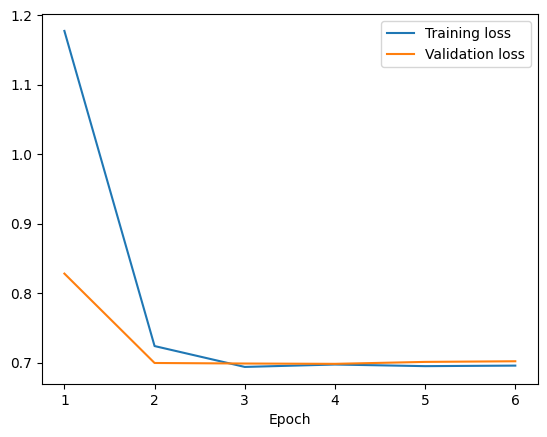

In [19]:
plot_losses(history)

In [20]:
tr_acc = accuracy_score(predict_hybrid(x_tr) >= 0.5, y_tr)
val_acc = accuracy_score(predict_hybrid(x_val) >= 0.5, y_val)
test_acc = accuracy_score(predict_hybrid(x_test) >= 0.5, y_test)
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)


Train accuracy: 0.67625
Validation accuracy: 0.69
Test accuracy: 0.69


In [21]:
import optuna

In [22]:
def objective(trial):
    # Define the learning rate as an optimizable parameter
    lrate = trial.suggest_float("learning_rate", 0.001, 0.1)
    
    # Reset the model with new learning rate
    global optimizer, classical_layer, qlayer
    
    # Reinitialize layers
    classical_layer = tf.keras.layers.Dense(4, activation="sigmoid")
    qlayer = QuantumLayer(qnn, n_params=n_params, output_dim=1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
    
    # Training loop (simplified version)
    train_losses_trial = []
    val_losses_trial = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_classical_weights = None
    best_quantum_weights = None
    
    for epoch in range(50):
        # Shuffle training data
        indices = np.random.permutation(len(x_tr))
        x_tr_shuffled = x_tr[indices]
        y_tr_shuffled = y_tr[indices]
        
        # Training
        epoch_losses = []
        num_batches = int(np.ceil(len(x_tr) / 10))
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * 10
            end_idx = min(start_idx + 10, len(x_tr))
            
            x_batch = x_tr_shuffled[start_idx:end_idx]
            y_batch = y_tr_shuffled[start_idx:end_idx]
            
            loss = train_step_hybrid(x_batch, y_batch)
            epoch_losses.append(loss.numpy())
        
        train_loss = np.mean(epoch_losses)
        val_loss = evaluate_hybrid(x_val, y_val)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_classical_weights = [w.numpy().copy() for w in classical_layer.trainable_variables]
            best_quantum_weights = qlayer.theta.numpy().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 2:
                for i, w in enumerate(classical_layer.trainable_variables):
                    w.assign(best_classical_weights[i])
                qlayer.theta.assign(best_quantum_weights)
                break
    
    # Return the validation accuracy
    return accuracy_score(predict_hybrid(x_val) >= 0.5, y_val)


In [23]:
from optuna.samplers import TPESampler

study = optuna.create_study(direction='maximize',
    sampler=TPESampler(seed = seed))

[I 2025-10-28 19:08:19,804] A new study created in memory with name: no-name-a5bcb1f3-b854-493a-8095-74bf7435414a


In [24]:
study.optimize(objective, n_trials=6)

[I 2025-10-28 19:26:22,068] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.01996042558751034}. Best is trial 0 with value: 0.5.
[I 2025-10-28 19:45:48,423] Trial 1 finished with value: 0.64 and parameters: {'learning_rate': 0.06258876833294336}. Best is trial 1 with value: 0.64.
[I 2025-10-28 20:15:52,226] Trial 2 finished with value: 0.66 and parameters: {'learning_rate': 0.04433504616170433}. Best is trial 2 with value: 0.66.
[I 2025-10-28 20:37:31,736] Trial 3 finished with value: 0.72 and parameters: {'learning_rate': 0.07875049978766316}. Best is trial 3 with value: 0.72.
[I 2025-10-28 20:47:47,597] Trial 4 finished with value: 0.57 and parameters: {'learning_rate': 0.07821760500376156}. Best is trial 3 with value: 0.72.
[I 2025-10-28 20:51:39,552] Trial 5 finished with value: 0.6 and parameters: {'learning_rate': 0.02798666792298152}. Best is trial 3 with value: 0.72.


In [25]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
x, y = make_classification(n_samples = 1000, n_features = 20,
    n_classes = 3, n_clusters_per_class = 1)

In [27]:
from sklearn.preprocessing import OneHotEncoder
hot = OneHotEncoder(sparse = False)
y_hot = hot.fit_transform(y.reshape(-1,1))

c:\Users\jebar\miniconda3\envs\myenv1\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
x_tr, x_test, y_tr, y_test = train_test_split(
    x, y_hot, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [29]:
nqubits = 4
dev_multi = qml.device("default.qubit", wires = nqubits)

def qnn_circuit_multi(inputs, theta):
    qml.AngleEmbedding(inputs, range(nqubits))
    TwoLocal(nqubits, theta, reps = 2)
    return [qml.expval(qml.Hermitian(M, wires = [0])),
            qml.expval(qml.Hermitian(M, wires = [1])),
            qml.expval(qml.Hermitian(M, wires = [2]))]

# Use autograd interface instead of TensorFlow for compatibility
qnn_multi = qml.QNode(qnn_circuit_multi, dev_multi, interface="autograd")

n_params_multi = 12  # For TwoLocal with reps=2 and 4 qubits


In [30]:
# Create quantum layer for multi-class classification
qlayer_multi = QuantumLayer(qnn_multi, n_params=n_params_multi, output_dim=3)

# Build the hybrid model for multi-class
dense1 = tf.keras.layers.Dense(8, activation="elu")
dense2 = tf.keras.layers.Dense(4, activation="sigmoid")
softmax_layer = tf.keras.layers.Activation(activation="softmax")

# Store references
optimizer_multi = tf.keras.optimizers.Adam(learning_rate=0.001)


In [31]:
# Custom training functions for multi-class classification
def forward_multi(x):
    """Forward pass through the entire multi-class model."""
    out = dense1(x)
    out = dense2(out)
    out = qlayer_multi(out)
    out = softmax_layer(out)
    return out

def train_step_multi(x_batch, y_batch):
    """Training step for multi-class model."""
    # Forward through classical layers
    out1 = dense1(x_batch)
    out2 = dense2(out1)
    
    # Forward through quantum layer
    quantum_out = qlayer_multi(out2)
    
    # Apply softmax
    predictions = softmax_layer(quantum_out)
    
    # Compute loss (categorical crossentropy)
    epsilon = 1e-7
    predictions_clipped = tf.clip_by_value(predictions, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(tf.reduce_sum(y_batch * tf.math.log(predictions_clipped), axis=1))
    
    # Compute gradients for quantum layer
    # d_loss/d_quantum_out (before softmax)
    d_loss_d_quantum = (predictions - y_batch) / len(y_batch)
    
    # Get quantum parameter gradients
    quantum_grads = qlayer_multi.compute_gradients(out2, d_loss_d_quantum.numpy())
    
    # Backpropagate through classical layers
    with tf.GradientTape() as tape:
        out1 = dense1(x_batch)
        out2 = dense2(out1)
        # Use a differentiable loss for classical layers
        quantum_out_copy = qlayer_multi(out2)
        predictions_copy = softmax_layer(quantum_out_copy)
        loss_classical = -tf.reduce_mean(tf.reduce_sum(y_batch * tf.math.log(
            tf.clip_by_value(predictions_copy, epsilon, 1 - epsilon)), axis=1))
    
    # Get classical gradients
    classical_vars = dense1.trainable_variables + dense2.trainable_variables
    classical_grads = tape.gradient(loss_classical, classical_vars)
    
    # Apply gradients
    optimizer_multi.apply_gradients([(quantum_grads, qlayer_multi.theta)])
    if classical_grads[0] is not None:
        optimizer_multi.apply_gradients(zip(classical_grads, classical_vars))
    
    return loss

def evaluate_multi(x, y):
    """Evaluate multi-class model."""
    predictions = forward_multi(x)
    epsilon = 1e-7
    predictions_clipped = tf.clip_by_value(predictions, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(tf.reduce_sum(y * tf.math.log(predictions_clipped), axis=1))
    return loss.numpy()

# Training loop for multi-class
import time

batch_size = 10
epochs = 50
patience = 2

train_losses_multi = []
val_losses_multi = []
best_val_loss = float('inf')
patience_counter = 0
best_weights = {}

print("Starting multi-class training...")
for epoch in range(epochs):
    epoch_start = time.time()
    
    # Shuffle training data
    indices = np.random.permutation(len(x_tr))
    x_tr_shuffled = x_tr[indices]
    y_tr_shuffled = y_tr[indices]
    
    # Training
    epoch_losses = []
    num_batches = int(np.ceil(len(x_tr) / batch_size))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(x_tr))
        
        x_batch = x_tr_shuffled[start_idx:end_idx]
        y_batch = y_tr_shuffled[start_idx:end_idx]
        
        loss = train_step_multi(x_batch, y_batch)
        epoch_losses.append(loss.numpy())
    
    # Calculate average training loss
    train_loss = np.mean(epoch_losses)
    train_losses_multi.append(train_loss)
    
    # Validation
    val_loss = evaluate_multi(x_val, y_val)
    val_losses_multi.append(val_loss)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.1f}s - "
          f"loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights['dense1'] = [w.numpy().copy() for w in dense1.trainable_variables]
        best_weights['dense2'] = [w.numpy().copy() for w in dense2.trainable_variables]
        best_weights['quantum'] = qlayer_multi.theta.numpy().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print("Restoring best weights...")
            for i, w in enumerate(dense1.trainable_variables):
                w.assign(best_weights['dense1'][i])
            for i, w in enumerate(dense2.trainable_variables):
                w.assign(best_weights['dense2'][i])
            qlayer_multi.theta.assign(best_weights['quantum'])
            break

# Store history
class HistoryMulti:
    def __init__(self):
        self.history = {
            'loss': train_losses_multi,
            'val_loss': val_losses_multi
        }

history = HistoryMulti()
print("\nMulti-class training complete!")


Starting multi-class training...
Epoch 1/50 - 98.1s - loss: 1.0878 - val_loss: 1.0966
Epoch 2/50 - 97.8s - loss: 1.0874 - val_loss: 1.0969
Epoch 3/50 - 97.4s - loss: 1.0870 - val_loss: 1.0972
Early stopping at epoch 3
Restoring best weights...

Multi-class training complete!


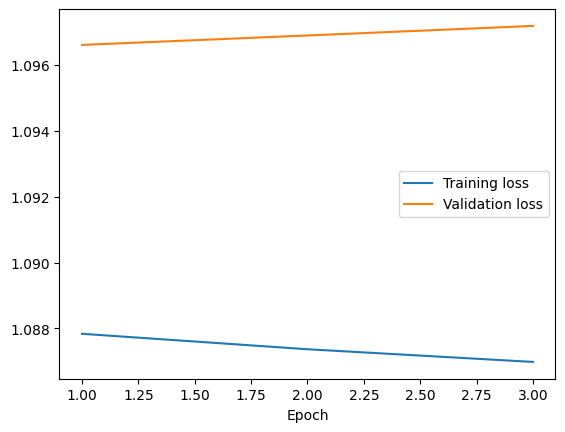

In [32]:
plot_losses(history)

In [33]:
tr_acc = accuracy_score(
    forward_multi(x_tr).numpy().argmax(axis=1),
    y_tr.argmax(axis=1))
val_acc = accuracy_score(
    forward_multi(x_val).numpy().argmax(axis=1),
    y_val.argmax(axis=1))
test_acc = accuracy_score(
    forward_multi(x_test).numpy().argmax(axis=1),
    y_test.argmax(axis=1))
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)


Train accuracy: 0.4125
Validation accuracy: 0.31
Test accuracy: 0.36
